# WEEK 9 HOMEWORK ASSIGNMENT
## Merging + analysis with WRF Hurricane Katrina data
- In this exercise, you'll be analyzing data from a WRF (a numerical weather prediction model) simulation of Hurricane Katrina
- Recall, a few weeks ago you previously learned a lot about this high-impact, devastating weather event on the Gulf Coast in 2005
<br><br>
- *Data - all at the SURFACE, and every 3 hours*
  - Reflect (reflectivity; precipitation intensity; dBZ)
  - Pres (pressure; lower pressures = stronger hurricane; mb)
  - Usfc (u-component, east-west, of wind; m/s)
  - Vsfc (v-component, north-south, of wind; m/s)
<br><br>
- Can't see this stunning satellite image below? 
https://www.weather.gov/images/mob/events/katrina/Hurr_Katrina_29Aug_Satellite2.png
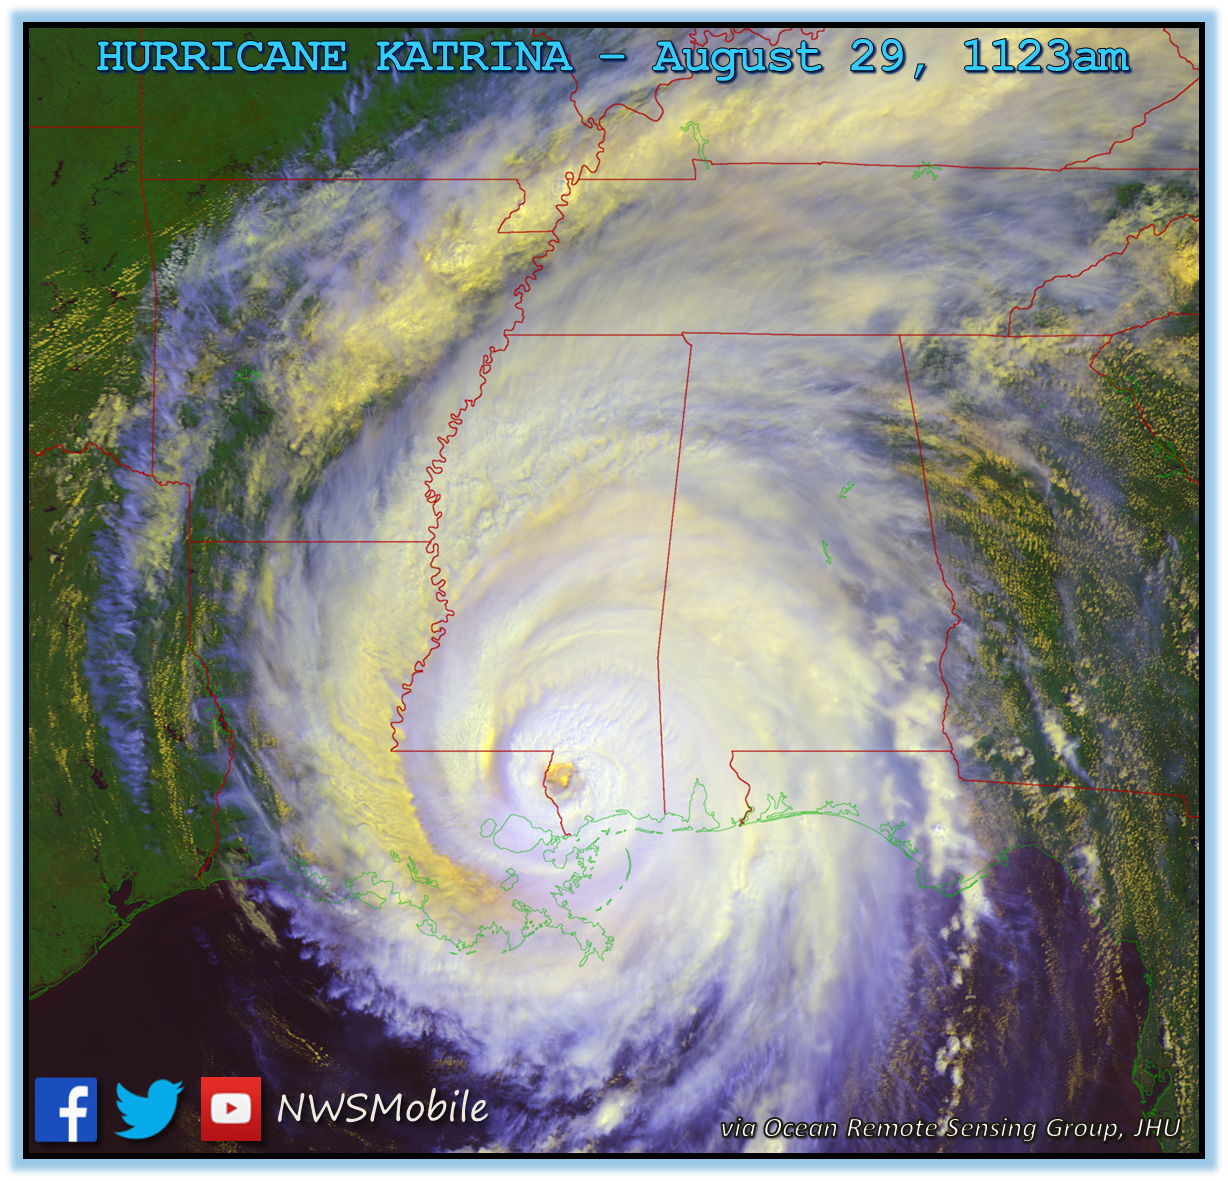

In [462]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import os
from os import path
import requests
import zipfile
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

#### (1)  First, download and read in the data
*(a.) Downloading*
- there are 25 files you'll download from rfd.atmos.uiuc.edu/Atms517/week9 - all begin with wrfout
<br><br>
- this is 6-hourly output from the WRF model, from August 27 at 12:00 to August 30 at 12:00
<br><br>
- you definitely want to use a clever way of downloading these in a bulk way rather than downloading them manually one at a time
<br><br>
- the files are pretty small, so no worry on size
<br><br>
- **KEY**: The data is on rfd both as 25 separate files and as a zip file of all 25 files called 'wrfout.zip' - likely easier to download and process the zip file!

In [463]:
base_u = 'http://rfd.atmos.uiuc.edu/Atms517/week9'
data_d = 'data/wrf'
f_uri = path.join(base_u, 'wrfout.zip')
r = requests.get(f_uri, allow_redirects=True)
of = path.join(data_d, 'wrfout.zip')
open(of, 'wb').write(r.content)
with zipfile.ZipFile(of, 'r') as zip_ref:
    zip_ref.extractall(data_d)
os.remove(of)

*(b.) Reading in the files*

In [464]:
pattern = path.join(data_d, 'wrfout_*')
files = glob.glob(pattern)
def get_df(f):
    print(f'Loading dataset from file: {f}')
    return xr.open_dataset(f)
dfs = [ get_df(f) for f in files ]
df0 = dfs[0]

Loading dataset from file: data/wrf/wrfout_d01_2005-08-28_18_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_00_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-27_15_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-28_09_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_09_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_03_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-28_21_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-30_06_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-28_03_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_06_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-28_06_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-30_12_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_18_00_00.nc
Loading dataset from file: data/wrf/wrfout_d01_2005-08-29_15_00_00.nc
Loading dataset from

#### (2) Next do some data processing
*I already added coordinates for your lat and longitude dimensions, changed order of dimensions, etc for you - the original WRF files were a bit barebones*
<br><br>
(a.)  What are the coordinates for any one data structure in your list?
<br><br>
(b.)  We want to, in the process of merging, merge along a new dimension that we'll create called time.  Create your merged data structure with this in mind!
<br><br>
(c.)  Print the *dimensions* of your new merged data structure.  
<br>
(d.)  Let's define *coordinates* for this new time dimension - I give you the code for this, if you'd like, in the *Hints* text file - just change the name of your dataset as needed.
- https://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html

In [465]:
# (a.)
print(df0["lon"])
print()
print(df0["lat"])

<xarray.DataArray 'lon' (lon: 89)>
array([-99.878174, -99.624176, -99.370056, -99.115814, -98.86151 , -98.607056,
       -98.35254 , -98.0979  , -97.84317 , -97.58835 , -97.333435, -97.07843 ,
       -96.823364, -96.56818 , -96.31293 , -96.05762 , -95.802216, -95.54675 ,
       -95.2912  , -95.03558 , -94.77991 , -94.52417 , -94.26837 , -94.01254 ,
       -93.75662 , -93.50067 , -93.24466 , -92.98859 , -92.73251 , -92.47635 ,
       -92.220184, -91.96396 , -91.7077  , -91.451416, -91.19513 , -90.93878 ,
       -90.682434, -90.426025, -90.16962 , -89.91321 , -89.6568  , -89.40036 ,
       -89.14392 , -88.88745 , -88.63098 , -88.37454 , -88.1181  , -87.86163 ,
       -87.605194, -87.348755, -87.09235 , -86.83597 , -86.57959 , -86.32321 ,
       -86.066895, -85.81055 , -85.55429 , -85.298035, -85.04181 , -84.785645,
       -84.52948 , -84.27338 , -84.017334, -83.76132 , -83.50537 , -83.24945 ,
       -82.99359 , -82.73779 , -82.482056, -82.22641 , -81.970795, -81.71524 ,
       -81.45978 

In [466]:
# (b.)
all_data = xr.concat(dfs, dim='time')

# (c.)
print(f'Dimensions of this data: {all_data.dims}')

# (d.)  You will find the code for this part in the 'Hints' text file - you're welcome to use it!  Just want to 
# give folks a chance to play around with some of this themselves first if they'd like 
timeseries=[]
for f in files:
    timeseries.append(path.basename(f).split("wrfout_d01_")[1].rstrip('.nc')) 
timeseries = pd.to_datetime(timeseries,format='%Y-%m-%d_%H_%M_%S')
all_data = all_data.assign_coords(time=('time', timeseries))

Dimensions of this data: Frozen({'time': 25, 'lat': 79, 'lon': 89})


### (2) Calculate wind speed - sqrt 
- (a.) Let's do a computation!  Calculate the wind speed and save as new data array
     - You have the U and V components of the wind - how would you calculate speed (magnitude)?
     - Think *vectors* - you have the x and y component of a vector, how would you get magnitude of the vector?
<br><br>
- (b.) Convert wind speed from m/s to mph 

In [467]:
# (a.)
a1 = all_data['Usfc']
a2 = all_data['Vsfc']
a1s = a1 ** 2
a2s = a2 ** 2
a1sa2s = a1s + a2s
windspeeds_m = a1sa2s**(1/2)
all_data['windspeeds_m'] = windspeeds_m
#print(f'Windspeeds in m/s: {windspeeds_m}')

In [468]:
# (b.)
all_data['windspeeds_mph'] = all_data['windspeeds_m'] * 2.23694
#print(f'Windspeeds in mph: {windspeeds_mph}')

### (3) Let's create some panel plots of wind speed and reflectivity
- (a.) First, let's *filter* reflectivity (Reflect) to only use values above 0
    - good practice filtering + makes our plots cleaner
<br><br>
- (b.) Next, create a panel plot consisting of EIGHT subplots that are MAPS, in total, for the times of 00:00, 06:00, 12:00, and 18:00 on August 29 - as the hurricane ~ landfalls

*PLOT REQUIREMENTS*
   - the FIRST column of subplots will be the reflectivity for these 4 times
   - the SECOND column of supblots will be wind speed for these 4 times
   - both should be filled contour or related type of plots
<br><br>
   - key things you MUST do/have:
     - zoom in so we can more closely see the hurricane, but ensure you include the whole hurricane in your frame: ax.set_extent([lon1,lon2,lat1,lat2])
     - titles
     - axis labels
     - colorbars/labels
     - coastlines
     - *state lines* (look into cartopy.feature!)
<br><br>

*HINTS*
- **hint #1**: see in-module exercise for a walkthrough of creating panel plots like these
<br><br>
- **hint #2**: for pretty and more meteorologically traditional plots, for reflectivity
    - use the jet colormap
<br><br>
- **hint #3**: to make your life easier re: adding coastlines, other features that will be the same for all subplots to each subplot
   - for ax in axes.flatten(): - allows you to access each of the 8 axises in the panel plot and do stuff to each of them in a loop
   - we need to use the flatten method b/c axes is a 2D array and as an interable object, it needs to be 1D
<br><br>

*Optional challenges*
  - include as text somewhere on each wind speed plot the maximum wind speed at that time, or any other interesting information :)
  - create a panel plot that has 2 or more variables overlayed on each subplot, making clever use of unfilled contours, hatching, and other ways of presenting more information in one plot

In [483]:
# (a.)
filtered_reflect = all_data.where( (all_data['Reflect'] > 0) )

# Now get the bounds for the maps
latmin = all_data['lat'].min()
latmax = all_data['lat'].max()
lonmin = all_data['lon'].min()
lonmax = all_data['lon'].max()
bounds = [ lonmin, lonmax, latmin, latmax ]

times = ['2005-08-29T00:00:00.000000000', '2005-08-29T06:00:00.000000000', 
         '2005-08-29T12:00:00.000000000', '2005-08-29T18:00:00.000000000']
plot_data = []
for t in times:
    # We want only the reflects > 0, but every wind speed, so do it twice
    filtered_selected_time = filtered_reflect.sel(time=t)
    all_data_selected_time = all_data.sel(time=t)
    
    reflects = filtered_selected_time['Reflect']
    winds = all_data_selected_time['windspeeds_mph']
    plot_data.append(
        (reflects.squeeze(), winds.squeeze())
    )

<Figure size 432x288 with 0 Axes>

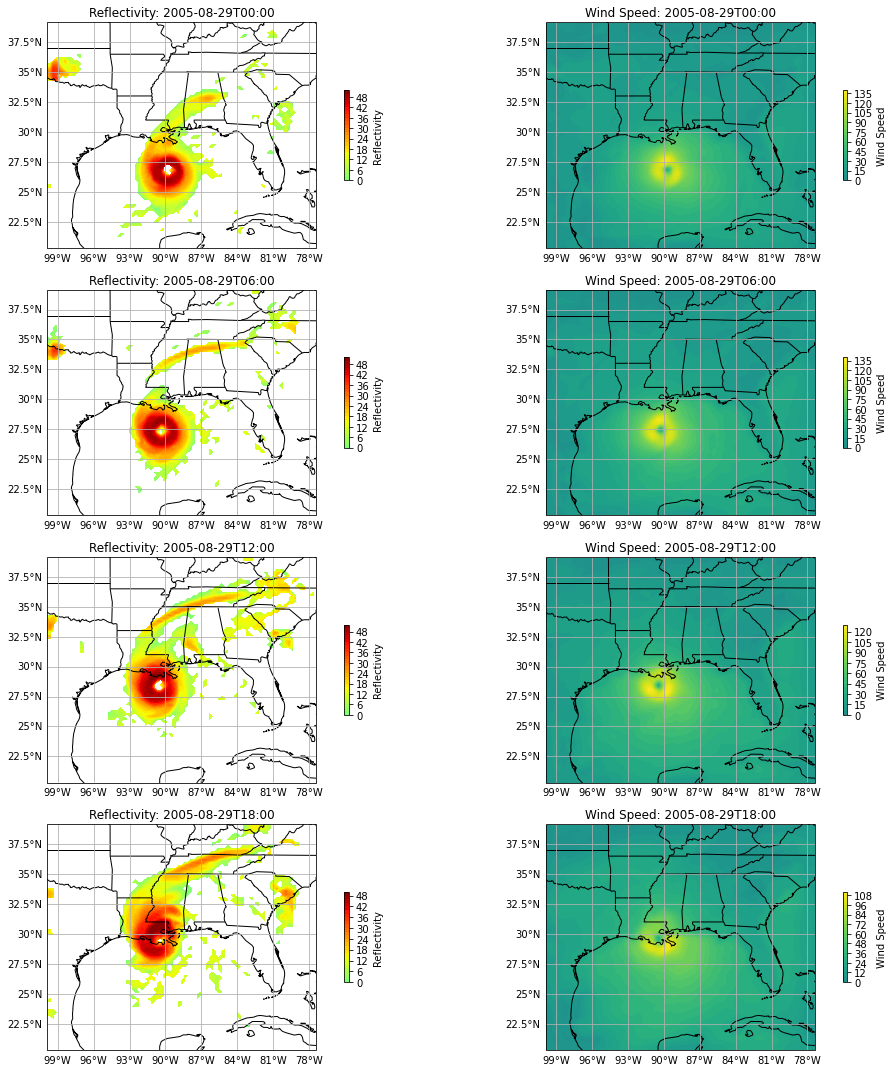

In [494]:
lon = all_data['lon']
lat = all_data['lat']
plt.tight_layout()
X, Y = np.meshgrid(lon, lat)
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(4, 2, figsize=(15,15), subplot_kw=dict(projection=proj))
for i, axa in enumerate(axs):
    time = times[i][:(times[i].find(':')+3)]
    for j in range(2):        
        ax = axa[j]
        ax.set_extent(bounds)
        ax.add_feature(
            cfeature.NaturalEarthFeature(
                'cultural', 'admin_1_states_provinces_lines','50m', edgecolor='black', facecolor='none'))
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.coastlines()
        if j % 2 == 0:
            ax.set_title(f'Reflectivity: {time}')
            cmap = 'jet'
            cs = ax.contourf(X, Y, plot_data[i][j], cmap=cmap, levels=30, norm=mcolors.TwoSlopeNorm(0))
            cb=fig.colorbar(cs,shrink=0.4, ax=ax)
            cb.set_label('Reflectivity')
        else:
            ax.set_title(f'Wind Speed: {time}')
            cmap = 'viridis'
            cs = ax.contourf(X, Y, plot_data[i][j], cmap=cmap, levels=30, norm=mcolors.TwoSlopeNorm(0))
            cb=fig.colorbar(cs,shrink=0.4, ax=ax)
            cb.set_label('Wind Speed')
plt.tight_layout()

### (4) Let's do a brief interpretation of your panel plot
*Relative to the "eye" of the hurricane (the reflectivity minimum and wind speed minimum in your above plots, in the center of the hurricane), where do you notice the*:
- (a.) Heaviest rain
<br><br>
- (b.) Highest winds
<br><br>
- (c.) Are these generally in the same region?

### (a.)
The eye wall contains the highest amount of rain.

### (b.)
The highest winds are also located in the eye wall of the storm.

### (c.)
Yes, both areas of highest impact are located around the eye of the storm.

### (5)  Finally - let's track the hurricane over time and plot its track!
- (a.)  One way to do this - find the (lat,lon) of the MINIMUM in surface pressure at each time (note: a hurricane is a strong low pressure system, with some other special characteristics)
  - You're going to do this for each time, and save your lats and lons of the minimum value of surface pressure in numpy arrays, one each for lat and lon
<br><br>
- (b.)  Create a map (with coastlines, statelines, etc.) with these 25 locations plotted, as a plot of the hurricane's track
<br><br>
- *Optional challenges*:
  - color code the dots by time, or minimum pressure, etc.
  - label the 00:00 observation for each day with the date of that day (so you'd have 4 labeled dots)
  - replot your plots in (3) to include a dot of the location of the minimum pressure in the hurricane for each of the times in a given subplot

Text(0.5, 1.0, '"Hold On to Your Butts - Samuel L. Jackson": August 29th, 2005')

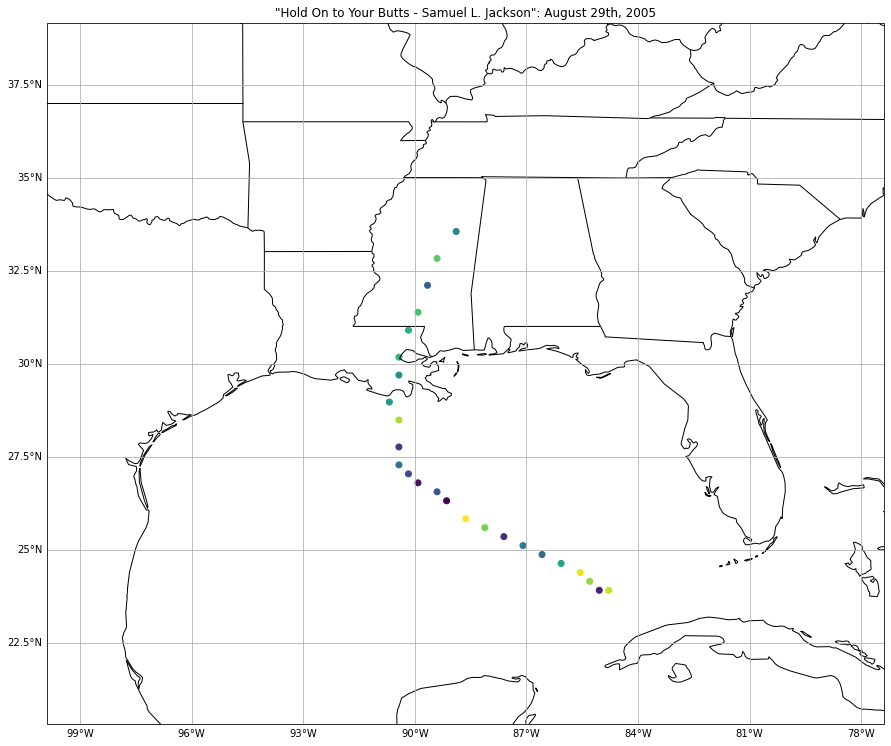

In [486]:
lons = []
lats = []
for t in timeseries:
    sel_time = all_data.sel(time=t)
    point = sel_time['Pres'].argmin(dim=['lat','lon'])
    lons.append(sel_time.isel(point)['lon'])
    lats.append(sel_time.isel(point)['lat'])

X, Y = np.meshgrid(lon, lat)
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=proj))
cmap=plt.get_cmap('plasma')
ax.set_extent(bounds)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines',
        '50m', edgecolor='black', facecolor='none'))
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.scatter(lons, lats, cmap='viridis', c=range(len(points)))
ax.set_title('"Hold On to Your Butts - Samuel L. Jackson": August 29th, 2005')

https://www.youtube.com/watch?v=-W6as8oVcuM